### Verificação de validade do CPF e CNPJ

#### Esse projeto visa validar o número do CPF e do CNPJ, assim como, formatar os números caso seja necessário

1. Verificar o que está configurado corretamente e o que não tá. 

    1) configuração CPF válido; configuração CNPJ válido; configuração CPF sem caracteres especiais; configuração CPF com espaço ou outros caracteres não compatíveis; configuração CNPJ sem caracteres especiais; configuração CNPJ com espaço ou outros caracteres não compatíveis; Número incorreto/incompleto.

    2) quando for classificado como “configuração CPF válido” ou “configuração CNPJ válido” não haverá necessidade de adequação e seguirá na listagem que realizaremos a consulta da validade por meio da API;

    3) quando for classificado como “configuração CPF sem caracteres especiais”, “configuração CPF com espaço ou outros caracteres não compatíveis”, “configuração CNPJ sem caracteres especiais”, “configuração CNPJ com espaço ou outros caracteres não compatíveis” deverá haver tratamento para ajuste na configuração e seguirá na listagem que realizaremos a consulta da validade por meio da API;
    
    4) quando for “Número incorreto/incompleto” não haverá tratamento ou ajuste e não seguirá para validação na API. 

2.	Validação dos casos indicados nos itens 2 e 3 pela API validando o CPF/CNPJ e trazendo para o CPF/CNPJ qual o nome da pessoa ou empresa.

3.	Identificar os CPFs e CNPJs vinculados a mais de 1 id de parte para definição de qual id deverá permanecer ativo e quais serão inativados. Categorizar:
    1) para as partes que só tiverem 1 único id categorizar como “Ativo – único cadastro”;
    2) para as partes que tiverem mais de 1 id e o nome bater igual ao do obtido na API categorizar como “Ativo – cadastro válido”;
    3) para as partes que tiverem mais de 1 id e o nome estiver com abreviação e tendo outro cadastro com o nome completo e igual ao obtido na API categorizar como “Inativo – cadastro nome abreviado” trazendo em outra coluna o id da parte do cadastro que será mantido;
    3) para as partes que tiverem mais de 1 id e o nome for divergente do obtido na API categorizar como “Inativo – parte inválida” e esses casos deverão ser buscados no tribunal;

4.	Extrair a base de processos do performa flow com base nas partes categorizadas como “Número incorreto/incompleto” e “Inativo – parte inválida” https://reports.elawio.com.br/Relatorio/Filtros?idRelatorio=48260 utilizando o filtro ID da Parte Adversa, para todos os status e todas as células. (Com ajuda do TI)

5.	Após definir cronograma e fluxo de saneamento de dados, inativação de partes. (Neste momento conversaremos eu e Rhuan)


In [4]:
import os
import pandas as pd
import numpy as np
import re
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from validate_docbr import CPF, CNPJ 

#### Carregamento da base de dados

> A base de dados em questão contém informações específicas sobre CPF e CNPJ. São duas bases diferentes que possuem a mesma coluna de referência.

In [5]:
BASE_DIR = os.path.dirname( os.getcwd() )
DATA_DIR = os.path.join( BASE_DIR, 'data' )

cpf_file_path = [ os.path.join( DATA_DIR, file ) for file in os.listdir(DATA_DIR) ][0]
cnpj_file_path = [ os.path.join( DATA_DIR, file ) for file in os.listdir(DATA_DIR) ][1]

df_cpf = pd.read_excel( cpf_file_path )
df_cnpj = pd.read_excel( cnpj_file_path )

display(df_cpf.head())
display(df_cnpj.head())

,ID,Nome,CPF/CNPJ,Tipo de Pessoa,Status
0,346801,WILZA MARINHO VERAS,489.736.702-63,Pessoa Física,Ativo
1,346804,FRANCISCO BERNARDO DA SILVA,188.325.634-87,Pessoa Física,Ativo
2,346808,MARIA DAS GRAÇAS OLIVEIRA,002.212.343-14,Pessoa Física,Ativo
3,346810,JOSE RIBAMAR PEREIRA DOS SANTOS,342.275.553-53,Pessoa Física,Ativo
4,346814,MARIA MATEUS DA ASSUNÇÃO LIMA,200.600.529-56,Pessoa Física,Ativo


,Id,Nome,CPF/CNPJ,Tipo de Pessoa,Status
0,630151,C OOPERATIVA D OS M ÉDICOS A N...,11.187.085/0001-85,Jurídica,Ativo
1,808372,\tFazenda Pública Estadual,12.200.192/0001-69,Jurídica,Ativo
2,1227493,HADAN ENGENHARIA INDUSTRIAL LTDA,NaN,Jurídica,Ativo
3,1182145,KODAK BRASILEIRA COMÉRCIO E INDÚSTRIA LTDA.,NaN,Jurídica,Ativo
4,775153,MARIZ COMERCIO ATACADISTA DE PRODUTOS AL,12.286.800/0001-08,Jurídica,Ativo


In [3]:
print(f'A base referente aos CPFs possui: {df_cpf.shape[0]} linhas.\nA base referente aos CNPJs possui: {df_cnpj.shape[0]} linhas')

A base referente aos CPFs possui: 532167 linhas.
A base referente aos CNPJs possui: 20420 linhas


In [4]:
display('As colunas da base CPF: ', df_cpf.columns)
display('As colunas da base CNPJ: ', df_cnpj.columns)

'As colunas da base CPF: '

Index(['ID', 'Nome', 'CPF/CNPJ', 'Tipo de Pessoa', 'Status'], dtype='object')

'As colunas da base CNPJ: '

Index(['Id', 'Nome', 'CPF/CNPJ', 'Tipo de Pessoa', 'Status'], dtype='object')

# CPF: Cadastro de Pessoas Físicas

#### Verificação da base de dados

In [5]:
df_cpf.head()

,ID,Nome,CPF/CNPJ,Tipo de Pessoa,Status
0,346801,WILZA MARINHO VERAS,489.736.702-63,Pessoa Física,Ativo
1,346804,FRANCISCO BERNARDO DA SILVA,188.325.634-87,Pessoa Física,Ativo
2,346808,MARIA DAS GRAÇAS OLIVEIRA,002.212.343-14,Pessoa Física,Ativo
3,346810,JOSE RIBAMAR PEREIRA DOS SANTOS,342.275.553-53,Pessoa Física,Ativo
4,346814,MARIA MATEUS DA ASSUNÇÃO LIMA,200.600.529-56,Pessoa Física,Ativo


In [6]:
df_cpf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532167 entries, 0 to 532166
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ID              532167 non-null  int64 
 1   Nome            532166 non-null  object
 2   CPF/CNPJ        493233 non-null  object
 3   Tipo de Pessoa  532167 non-null  object
 4   Status          532167 non-null  object
dtypes: int64(1), object(4)
memory usage: 20.3+ MB


In [12]:
df_cpf.isna().sum()

ID                    0
Nome                  1
CPF/CNPJ          38934
Tipo de Pessoa        0
Status                0
dtype: int64

#### Identificando os valores ausentes presentes na coluna 'CPF/CNPJ'

In [13]:
# Identificando os valores ausentes na coluna 'CPF/CNPJ' e substituindo os seus valores por "Não Consta"
df_cpf.loc[df_cpf['CPF/CNPJ'].isna(), 'CPF/CNPJ'] = 'Não Consta'

In [14]:
# Verificação da quantidade de valores ausentes depois do tratamento da coluna 'CPF/CNPJ'
df_cpf.isna().sum()

ID                0
Nome              1
CPF/CNPJ          0
Tipo de Pessoa    0
Status            0
dtype: int64

In [15]:
df_cpf.loc[df_cpf['CPF/CNPJ'].isna()]

,ID,Nome,CPF/CNPJ,Tipo de Pessoa,Status


In [16]:
# Alterando todos os registros da coluna 'CPF/CNPJ' para string
df_cpf['CPF/CNPJ'] = df_cpf['CPF/CNPJ'].astype('str')

In [26]:
cpf = CPF()

def validar_cpf(numero_cpf: str):
    if numero_cpf:
        novo_numero_cpf = re.sub(r'\D', '', numero_cpf).strip()
        
        if len(novo_numero_cpf) == 11:
            if re.match(r'^\d{3}\.\d{3}\.\d{3}-\d{2}$', numero_cpf):
                if cpf.validate(novo_numero_cpf):
                    return {
                        'CPF': numero_cpf,
                        'API': novo_numero_cpf,
                        'Condição': 'Válido',
                        'Descrição': 'Com pontuação especial'
                    }
            elif cpf.validate(novo_numero_cpf):
                cpf_formatado = cpf.mask(novo_numero_cpf)
                return {
                    'CPF': cpf_formatado,
                    'API': novo_numero_cpf,
                    'Condição': 'Válido',
                    'Descrição': 'Sem pontuação especial'
                }
    return {
        'CPF': numero_cpf,
        'API': novo_numero_cpf,
        'Condição': 'Inválido',
        'Descrição': 'CPF inválido ou formato incorreto'
    }

def validar_cpfs_dataframe(df, coluna_cpf):
    resultados = df[coluna_cpf].apply(validar_cpf)
    df_resultados = pd.DataFrame(resultados.tolist())
    return df_resultados


# data = {'CPFs': ['12345678909', '987.....654..321-00', '095.644.254-41']}
# df = pd.DataFrame(data)

# Valida e formata os CPFs na coluna 'CPFs'
df_resultados = validar_cpfs_dataframe(df_cpf, 'CPF/CNPJ')
display(df_resultados)


,CPF,API,Condição,Descrição
0,489.736.702-63,48973670263,Válido,Com pontuação especial
1,188.325.634-87,18832563487,Válido,Com pontuação especial
2,002.212.343-14,00221234314,Válido,Com pontuação especial
3,342.275.553-53,34227555353,Válido,Com pontuação especial
4,200.600.529-56,20060052956,Inválido,CPF inválido ou formato incorreto
...,...,...,...,...
532162,020.391.963-74,02039196374,Válido,Com pontuação especial
532163,010.340.345-02,01034034502,Válido,Com pontuação especial
532164,543.310.213-00,54331021300,Válido,Com pontuação especial
532165,847.449.013-87,84744901387,Válido,Com pontuação especial


#### Exportando a base de dados com a verificação final

In [29]:
# Salvar o arquivo em formato Excel dentro da pasta de 'data'
FILE_PATH_CPF = os.path.join(DATA_DIR, 'validacao_cpf.xlsx')
df_resultados.to_excel(FILE_PATH_CPF, index=False)

#### Carregando a base de dados de validação

In [2]:
# Carregar a base de dados
validacao_cpf = pd.read_excel(r'C:\Users\victoramarante\Documents\7.automacao_validacao_cpfcnpj_AnaValenca\data\validacao_cpf.xlsx')
validacao_cpf.head()

,CPF,API,Condição,Descrição
0,489.736.702-63,48973670263,Válido,Com pontuação especial
1,188.325.634-87,18832563487,Válido,Com pontuação especial
2,002.212.343-14,00221234314,Válido,Com pontuação especial
3,342.275.553-53,34227555353,Válido,Com pontuação especial
4,200.600.529-56,20060052956,Inválido,CPF inválido ou formato incorreto


In [3]:
validacao_cpf.shape

(532167, 4)

In [24]:
# Verificar se os CPFs ausentes registrados como "Não Consta" estão com Condição Inválida
validacao_cpf.loc[(validacao_cpf['Condição'] == 'Inválido') &
                  (validacao_cpf['CPF'] == 'Não Consta')]

,CPF,API,Condição,Descrição
106,Não Consta,NaN,Inválido,CPF inválido ou formato incorreto
167,Não Consta,NaN,Inválido,CPF inválido ou formato incorreto
528,Não Consta,NaN,Inválido,CPF inválido ou formato incorreto
1011,Não Consta,NaN,Inválido,CPF inválido ou formato incorreto
1804,Não Consta,NaN,Inválido,CPF inválido ou formato incorreto
...,...,...,...,...
531702,Não Consta,NaN,Inválido,CPF inválido ou formato incorreto
531703,Não Consta,NaN,Inválido,CPF inválido ou formato incorreto
531704,Não Consta,NaN,Inválido,CPF inválido ou formato incorreto
531705,Não Consta,NaN,Inválido,CPF inválido ou formato incorreto


In [25]:
display(validacao_cpf['Condição'].value_counts())
display(validacao_cpf['Condição'].value_counts(normalize=True)*100)

Condição
Válido      483050
Inválido     49117
Name: count, dtype: int64

Condição
Válido      90.770378
Inválido     9.229622
Name: proportion, dtype: float64

In [33]:
condicao_cpf = pd.DataFrame(validacao_cpf['Condição'].value_counts())
condicao_cpf.reset_index(inplace=True)
condicao_cpf

,Condição,count
0,Válido,483050
1,Inválido,49117


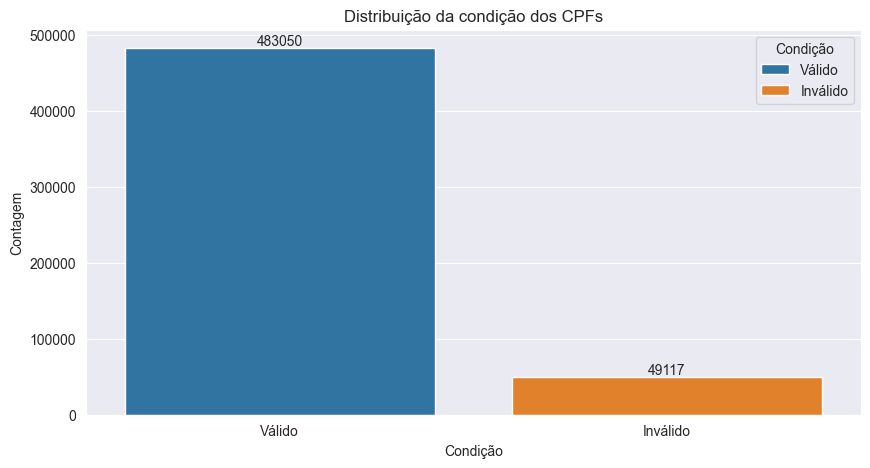

In [35]:
sns.set_style("darkgrid")
plt.figure(figsize=(10,5))
ax = sns.barplot(condicao_cpf, x="Condição", y="count", hue='Condição', legend=True, estimator="sum")
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
plt.title('Distribuição da condição dos CPFs')
plt.ylabel('Contagem')
plt.show()

In [41]:
cpf_invalidos = validacao_cpf.loc[(validacao_cpf['Condição'] == 'Inválido') &
                                  (validacao_cpf['CPF'] == 'Não Consta')]
cpf_invalidos


,CPF,API,Condição,Descrição
106,Não Consta,NaN,Inválido,CPF inválido ou formato incorreto
167,Não Consta,NaN,Inválido,CPF inválido ou formato incorreto
528,Não Consta,NaN,Inválido,CPF inválido ou formato incorreto
1011,Não Consta,NaN,Inválido,CPF inválido ou formato incorreto
1804,Não Consta,NaN,Inválido,CPF inválido ou formato incorreto
...,...,...,...,...
531702,Não Consta,NaN,Inválido,CPF inválido ou formato incorreto
531703,Não Consta,NaN,Inválido,CPF inválido ou formato incorreto
531704,Não Consta,NaN,Inválido,CPF inválido ou formato incorreto
531705,Não Consta,NaN,Inválido,CPF inválido ou formato incorreto


Essa primeira parte do relatório está relacionada com a verificação e validação dos CPFs que estão presentes em nossa base de dados no Performa. Ao todo, temos **532.167 registros** para serem analisados dentro dos quais 483.050 **(90.77%)** estão classificados como **Válidos** e 49.117 **(9.22%)** estão classificados como **Inválidos**.

# CNPJ: Cadastro Nacional da Pessoa Jurídica

#### Verificação da base de dados

In [7]:
df_cnpj.head()

,Id,Nome,CPF/CNPJ,Tipo de Pessoa,Status
0,630151,C OOPERATIVA D OS M ÉDICOS A N...,11.187.085/0001-85,Jurídica,Ativo
1,808372,\tFazenda Pública Estadual,12.200.192/0001-69,Jurídica,Ativo
2,1227493,HADAN ENGENHARIA INDUSTRIAL LTDA,NaN,Jurídica,Ativo
3,1182145,KODAK BRASILEIRA COMÉRCIO E INDÚSTRIA LTDA.,NaN,Jurídica,Ativo
4,775153,MARIZ COMERCIO ATACADISTA DE PRODUTOS AL,12.286.800/0001-08,Jurídica,Ativo


In [8]:
df_cnpj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20420 entries, 0 to 20419
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              20420 non-null  int64 
 1   Nome            20419 non-null  object
 2   CPF/CNPJ        13575 non-null  object
 3   Tipo de Pessoa  20420 non-null  object
 4   Status          20420 non-null  object
dtypes: int64(1), object(4)
memory usage: 797.8+ KB


In [9]:
df_cnpj.isna().sum()

Id                   0
Nome                 1
CPF/CNPJ          6845
Tipo de Pessoa       0
Status               0
dtype: int64

In [10]:
# Identificando os valores ausentes na coluna 'CPF/CNPJ' e substituindo os seus valores por "Não Consta"
df_cnpj.loc[df_cnpj['CPF/CNPJ'].isna(), 'CPF/CNPJ'] = 'Não Consta'

In [11]:
df_cnpj.isna().sum()

Id                0
Nome              1
CPF/CNPJ          0
Tipo de Pessoa    0
Status            0
dtype: int64

In [12]:
df_cnpj.head()

,Id,Nome,CPF/CNPJ,Tipo de Pessoa,Status
0,630151,C OOPERATIVA D OS M ÉDICOS A N...,11.187.085/0001-85,Jurídica,Ativo
1,808372,\tFazenda Pública Estadual,12.200.192/0001-69,Jurídica,Ativo
2,1227493,HADAN ENGENHARIA INDUSTRIAL LTDA,Não Consta,Jurídica,Ativo
3,1182145,KODAK BRASILEIRA COMÉRCIO E INDÚSTRIA LTDA.,Não Consta,Jurídica,Ativo
4,775153,MARIZ COMERCIO ATACADISTA DE PRODUTOS AL,12.286.800/0001-08,Jurídica,Ativo


In [13]:
# Alterando todos os registros da coluna 'CPF/CNPJ' para string
df_cpf['CPF/CNPJ'] = df_cpf['CPF/CNPJ'].astype('str')

In [24]:
cnpj = CNPJ()

def validar_cnpj(numero_cnpj: str):
    if numero_cnpj:
        novo_numero_cnpj = re.sub(r'\D', '', numero_cnpj).strip()
        
        if len(novo_numero_cnpj) == 14:
            if re.match(r'^\d{2}\.\d{3}\.\d{3}/\d{4}-\d{2}$', numero_cnpj):
                if cnpj.validate(novo_numero_cnpj):
                    return {
                        'Documento': numero_cnpj,
                        'API': novo_numero_cnpj,
                        'Condição': 'Válido',
                        'Descrição': 'CNPJ com pontuação especial'
                    }
            elif cnpj.validate(novo_numero_cnpj):
                cnpj_formatado = cnpj.mask(novo_numero_cnpj)
                return {
                    'Documento': cnpj_formatado,
                    'API': novo_numero_cnpj,
                    'Condição': 'Válido',
                    'Descrição': 'CNPJ sem pontuação especial'
                }
    return {
        'Documento': numero_cnpj,
        'API': novo_numero_cnpj,
        'Condição': 'Inválido',
        'Descrição': 'CNPJ inválido ou formato incorreto'
    }

def validar_cnpjs_dataframe(df, coluna_cpf):
    df[coluna_cpf] = df[coluna_cpf].astype(str)
    resultados = df[coluna_cpf].apply(validar_cnpj)
    df_resultados = pd.DataFrame(resultados.tolist())
    return df_resultados

df_resultados_cnpj = validar_cnpjs_dataframe(df_cnpj, 'CPF/CNPJ')
display(df_resultados_cnpj)

,Documento,API,Condição,Descrição
0,11.187.085/0001-85,11187085000185,Válido,CNPJ com pontuação especial
1,12.200.192/0001-69,12200192000169,Válido,CNPJ com pontuação especial
2,Não Consta,,Inválido,CNPJ inválido ou formato incorreto
3,Não Consta,,Inválido,CNPJ inválido ou formato incorreto
4,12.286.800/0001-08,12286800000108,Válido,CNPJ com pontuação especial
...,...,...,...,...
20415,Não Consta,,Inválido,CNPJ inválido ou formato incorreto
20416,Não Consta,,Inválido,CNPJ inválido ou formato incorreto
20417,17.197.385/0001-21,17197385000121,Válido,CNPJ com pontuação especial
20418,Não Consta,,Inválido,CNPJ inválido ou formato incorreto


#### Exportando a base de dados de verificação do CNPJ

In [22]:
# Salvar o arquivo em formato Excel dentro da pasta de 'data'
FILE_PATH_CPF = os.path.join(DATA_DIR, 'validacao_cnpj.xlsx')
df_resultados_cnpj.to_excel(FILE_PATH_CPF, index=False)

NameError: name 'df_resultados_cnpj' is not defined

#### Extrair as informações dos CNPJs via API

In [114]:
# def extrair_infos_cnpj(numero_cnpj):
#     url = f"https://brasilapi.com.br/api/cnpj/v1/{numero_cnpj}"
#     try:
#         response = requests.request("GET", url,)
#         response.raise_for_status()  # Raise an exception for 4xx or 5xx errors
#         json_res = response.json()
#         if 'message' in json_res:
#             return None
#         elif 'razao_social' in json_res:
#             return json_res['razao_social']
#         else:
#             return None
#     except (requests.exceptions.HTTPError, requests.exceptions.RequestException) as e:
#         print(f"Error fetching data: {e}")
#         return None
#     except json.JSONDecodeError as e:
#         print(f"Error decoding JSON: {e}")
#         return None


# PRECISAMOS AUMENTAR O TEMPO PARA SOLICITAR AS INFORMAÇÕES DA API POR CAUSA DO RATE LIMIT
# data = {'CNPJs': ['12345678909', '987.....654..321-00', '111.222.333-44', '12.345.678/0001-95', '12345678000195']}
# df = pd.read_excel(r'C:\Users\victoramarante\Documents\7.automacao_validacao_cpfcnpj_AnaValenca\data\2. Adverso - Pessoa Jurídica.xlsx')
# df = df.iloc[0:15,]
# df_resultados_cnpj = validar_cpfs_dataframe(df, 'CPF/CNPJ')
# df_cnpj_validos = df_resultados_cnpj[df_resultados_cnpj['Condição'] == 'Válido']
# df_cnpj_validos
# lista_razao_social = [ extrair_infos_cnpj(cnpj) for cnpj in df_cnpj_validos['API'].tolist() ]
# lista_razao_social
# df_cnpj_validos['Razão Social'] = lista_razao_social

# df_resultados_cnpj.to_excel('CNPJs_Validacao.xlsx', index=False)


['COOPERATIVA DOS MEDICOS ANESTESIOLOGISTAS DE PERNAMBUCO COOPANEST PE',
 'SECRETARIA DE ESTADO DA FAZENDA',
 'MARIZ COMERCIO ATACADISTA DE PRODUTOS ALIMENTICIOS EM GERAL LTDA - FALIDO',
 'MERCO-QUIMICA DO BRASIL LTDA FALIDO',
 'PAULISTA II - FUNDO DE INVESTIMENTO RENDA FIXA PETROS CREDITO PRIVADO',
 'AUTO POSTO TUTTIS LTDA',
 'AGENCIA NACIONAL DE TRANSPORTES TERRESTRES - ANTT',
 'AGJS REVENDA E TRANSPORTE DE GAS LTDA',
 'AGROFIELD ASSESSORIA ADMINISTRATIVA LTDA',
 'ALESSANDRO DE CARVALHO E SOUZA',
 'ATL - ANDRADE TRANSPORTES LTDA',
 'ANTONIO LOPES DE OLIVEIRA DE SALVADOR LTDA',
 'ARCA EMPACOTAMENTO LTDA']

In [6]:
validacao_cnpj = pd.read_excel(r'C:\Users\victoramarante\Documents\7.automacao_validacao_cpfcnpj_AnaValenca\data\validacao_cnpj.xlsx')
validacao_cnpj.head()

,Documento,API,Condição,Descrição
0,11.187.085/0001-85,1.118709e+13,Válido,CNPJ com pontuação especial
1,12.200.192/0001-69,1.220019e+13,Válido,CNPJ com pontuação especial
2,Não Consta,NaN,Inválido,CNPJ inválido ou formato incorreto
3,Não Consta,NaN,Inválido,CNPJ inválido ou formato incorreto
4,12.286.800/0001-08,1.228680e+13,Válido,CNPJ com pontuação especial


In [7]:
display(validacao_cnpj['Condição'].value_counts())
display(validacao_cnpj['Condição'].value_counts(normalize=True)*100)

Condição
Válido      13050
Inválido     7370
Name: count, dtype: int64

Condição
Válido      63.907933
Inválido    36.092067
Name: proportion, dtype: float64

In [8]:
condicao_cnpj = pd.DataFrame(validacao_cnpj['Condição'].value_counts())
condicao_cnpj.reset_index(inplace=True)
condicao_cnpj

,Condição,count
0,Válido,13050
1,Inválido,7370


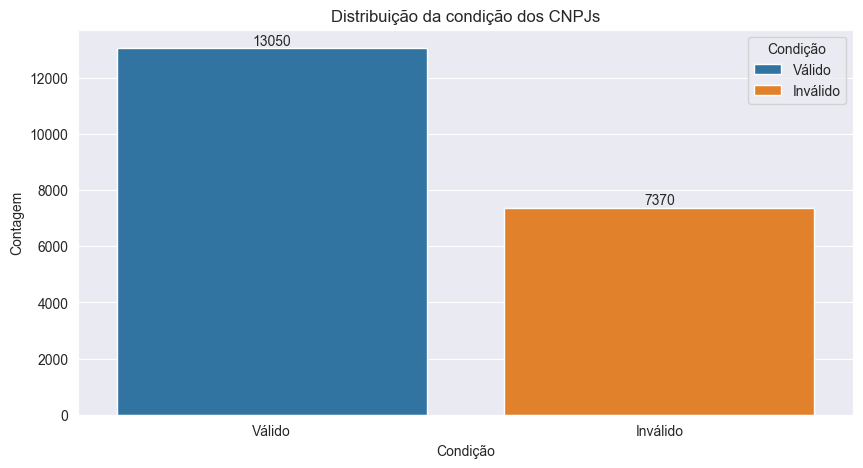

In [9]:
sns.set_style("darkgrid")
plt.figure(figsize=(10,5))
ax = sns.barplot(condicao_cnpj, x="Condição", y="count", hue='Condição', legend=True, estimator="sum")
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
plt.title('Distribuição da condição dos CNPJs')
plt.ylabel('Contagem')
plt.show()

CPF e CNPJ podem ser escritos:
- Com pontuação
- Sem pontuação

Das duas formas conseguimos validar se um CPF ou CNPJ é válido ou não. Isso facilita o processo de verificação e diminuir significativamente o tempo de análise.

Ademais, conseguimos realizar a verificação para uma lista de CPFs e CNPJs.

Ademais-2, conseguimos realizar a formatação do CPF e CNPJ

> Conseguimos retornar para o usuário uma tabela com as informações sobre os CPF e CNPJ que estão distribuídos dentro da base de dados

### Testando API de CNPJ
> Objetivo de resgatar as informações sobre o CNPJ em questão

In [10]:
import requests
import json
from time import sleep

In [11]:
validacao_cnpj.head()

,Documento,API,Condição,Descrição
0,11.187.085/0001-85,1.118709e+13,Válido,CNPJ com pontuação especial
1,12.200.192/0001-69,1.220019e+13,Válido,CNPJ com pontuação especial
2,Não Consta,NaN,Inválido,CNPJ inválido ou formato incorreto
3,Não Consta,NaN,Inválido,CNPJ inválido ou formato incorreto
4,12.286.800/0001-08,1.228680e+13,Válido,CNPJ com pontuação especial


In [12]:
validacao_cnpj['API'] = validacao_cnpj['API'].apply(lambda x: f"{int(x):014d}" if pd.notna(x) else pd.NA)


In [13]:
apis = validacao_cnpj[validacao_cnpj['Condição'] == 'Válido']['API'].tolist()
display(apis)
display(len(apis))

['11187085000185',
 '12200192000169',
 '12286800000108',
 '03227814000151',
 '11144274000170',
 '19507792000113',
 '04898488000177',
 '09264249000189',
 '06284974000120',
 '26963227000207',
 '04719485000129',
 '04021803000183',
 '10621452000144',
 '21642355000154',
 '18604562000100',
 '55983670000167',
 '35883557000100',
 '13396337000101',
 '29941561000177',
 '32604981000172',
 '60770336000165',
 '60746948000112',
 '00000000000191',
 '00000000000191',
 '17184037000110',
 '17184037000110',
 '17184037000110',
 '17184037000110',
 '17184037000110',
 '60814191000157',
 '90400888000142',
 '90400888000142',
 '90400888000142',
 '90400888000142',
 '90400888000142',
 '90400888000142',
 '90400888000142',
 '90400888000142',
 '60889128000180',
 '60975174000100',
 '07353102000130',
 '16284689000163',
 '09612603000119',
 '15689185000160',
 '03010559000271',
 '15694005000139',
 '40814428000192',
 '18198000000103',
 '07134125000153',
 '04065033000170',
 '11089428000179',
 '54037916012402',
 '1584280100

13050

In [15]:
def extrair_infos_cnpj(numero_cnpj):
    url = f"https://brasilapi.com.br/api/cnpj/v1/{numero_cnpj}"
    try:
        response = requests.request("GET", url,)
        response.raise_for_status()  # Raise an exception for 4xx or 5xx errors
        json_res = response.json()
        if 'message' in json_res:
            return None
        elif 'razao_social' in json_res:
            return json_res['razao_social']
        else:
            return None
    except (requests.exceptions.HTTPError, requests.exceptions.RequestException) as e:
        print(f"Error fetching data: {e}")
        return None
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
        return None

In [16]:
type(apis)

list

In [17]:
len(apis)

13050

In [1]:
razao_social = []
print(f'Temos uma base de {len(apis)}')
for index, api in enumerate(apis):
    resp = extrair_infos_cnpj(api)
    razao_social.append(resp)
    print(f'{index+1} - CNPJ {api} extraído')
    # sleep(0.5)
print('Processo finalizado')

NameError: name 'apis' is not defined

In [40]:
razao_social

['COOPERATIVA DOS MEDICOS ANESTESIOLOGISTAS DE PERNAMBUCO COOPANEST PE',
 'SECRETARIA DE ESTADO DA FAZENDA',
 'MARIZ COMERCIO ATACADISTA DE PRODUTOS ALIMENTICIOS EM GERAL LTDA - FALIDO',
 'MERCO-QUIMICA DO BRASIL LTDA FALIDO',
 'PAULISTA II - FUNDO DE INVESTIMENTO RENDA FIXA PETROS CREDITO PRIVADO',
 'AUTO POSTO TUTTIS LTDA',
 'AGENCIA NACIONAL DE TRANSPORTES TERRESTRES - ANTT',
 'AGJS REVENDA E TRANSPORTE DE GAS LTDA',
 'AGROFIELD ASSESSORIA ADMINISTRATIVA LTDA',
 'ALESSANDRO DE CARVALHO E SOUZA',
 'ATL - ANDRADE TRANSPORTES LTDA',
 'ANTONIO LOPES DE OLIVEIRA DE SALVADOR LTDA',
 'ARCA EMPACOTAMENTO LTDA',
 'ARGON COMERCIALIZADORA DE ENERGIAS LTDA - EM RECUPERACAO JUDICIAL',
 'ASSOCIACAO AMIGOS DA REGIAO SUL',
 'ASSOCIACAO DE ENSINO DE RIBEIRAO PRETO',
 'AURORA ENERGIAS RENOVAVEIS IX LTDA',
 'AUTO POSTO DE COMBUSTIVEIS REI DO AGRESTE LTDA',
 'MARTINS SEGUROS LTDA',
 'AUTOPOSTO DE COMBUSTIVEL MASP BRENNAND LTDA',
 'BANCO ALFA DE INVESTIMENTO S.A.',
 'BANCO BRADESCO S.A.',
 'BANCO DO BRA

In [ ]:
validos = validacao_cnpj[validacao_cnpj['Condição'] == 'Válido']

In [ ]:
validos['Razão Social'] = pd.Series(razao_social).reindex(validos.index)
validos

C:\Users\victoramarante\AppData\Local\Temp\ipykernel_4316\627720930.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validos['Razão Social'] = pd.Series(razao_social).reindex(validos.index)


,Documento,API,Condição,Descrição,Razão Social
0,11.187.085/0001-85,11187085000185,Válido,CNPJ com pontuação especial,COOPERATIVA DOS MEDICOS ANESTESIOLOGISTAS DE P...
1,12.200.192/0001-69,12200192000169,Válido,CNPJ com pontuação especial,SECRETARIA DE ESTADO DA FAZENDA
4,12.286.800/0001-08,12286800000108,Válido,CNPJ com pontuação especial,PAULISTA II - FUNDO DE INVESTIMENTO RENDA FIXA...
5,03.227.814/0001-51,03227814000151,Válido,CNPJ com pontuação especial,AUTO POSTO TUTTIS LTDA
6,11.144.274/0001-70,11144274000170,Válido,CNPJ com pontuação especial,AGENCIA NACIONAL DE TRANSPORTES TERRESTRES - ANTT
...,...,...,...,...,...
20412,01.297.815/0001-47,01297815000147,Válido,CNPJ com pontuação especial,NaN
20413,70.209.861/0001-60,70209861000160,Válido,CNPJ com pontuação especial,NaN
20414,01.451.373/0001-41,01451373000141,Válido,CNPJ com pontuação especial,NaN
20417,17.197.385/0001-21,17197385000121,Válido,CNPJ com pontuação especial,NaN


In [ ]:
validos.to_excel('teste_validos.xlsx', index=False)